# 🧪 Group6_Project: California Google Local Business Analysis with PyMongo + Spark
This lab simulates a real-world big data pipeline using **MongoDB**, **PySpark**, and the **California Google Local Business Dataset**.
We'll:
- Insert data into MongoDB from JSON
- Load that data into Spark
- Perform analysis
- Save results back to MongoDB


## 📥 Step 1: Insert Google Local Data into MongoDB

In [25]:
import json
from pymongo import MongoClient
from pyspark.sql.functions import col, explode, count, avg, row_number, to_date, regexp_replace, lower, length


# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["group6_bigdata"]

# Drop old collections if they exist
db["meta"].drop()
db["review"].drop()

# === Trim and load only first 1000 businesses ===
with open("meta-California.json", "r", encoding="utf-8") as f:
    meta_data = [json.loads(line) for _, line in zip(range(1000), f)]
db["meta"].insert_many(meta_data)
print(f"✅ Inserted {len(meta_data)} meta")


# === Trim and load only first 5000 reviews ===
with open("review-California_10.json", "r", encoding="utf-8") as f:
    review_data = [json.loads(line) for _, line in zip(range(5000), f)]
db["review"].insert_many(review_data)
print(f"✅ Inserted {len(review_data)} reviews")



✅ Inserted 1000 meta
✅ Inserted 5000 reviews


## ⚙️ Step 2: Start Spark Session

In [26]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("group6_bigdata").getOrCreate()

## 📊 Step 3: Load Data from MongoDB via PyMongo

In [27]:
# assign typeValue for each feature of meta_dataset

from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, ArrayType

schema_meta = StructType([
    StructField("name", StringType(), True),
    StructField("address", StringType(), True),
    StructField("avg_rating", DoubleType(), True),     
    StructField("category", ArrayType(StringType()), True),   
    StructField("description", StringType(), True),
    StructField("gmap_id", StringType(), True),
    StructField("hours", StringType(), True),
    StructField("latitude", StringType(), True),
    StructField("longitude", StringType(), True),
    StructField("num_of_reviews", IntegerType(), True),
    StructField("price", DoubleType(), True),
    StructField("relative_results", StringType(), True),
    StructField("state", StringType(), True),
    StructField("url", StringType(), True),

])

# df_meta = spark.createDataFrame(meta_docs, schema=schema)

In [28]:
# assign typeValue for each feature of reviews_dataset
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType

# Define schema with the correct type for the 'time' field
schema_review = StructType([
    StructField("gmap_id", StringType(), True),
    StructField("name", StringType(), True),
    StructField("pics", StringType(), True),
    StructField("rating", IntegerType(), True),
    # StructField("resp", StringType(), True),
    StructField("text", StringType(), True),
    StructField("time", TimestampType(), True),  # Changed to TimestampType
    StructField("user_id", StringType(), True)
])



In [29]:
#clean data in the case data has multiple types

# for meta_dataset
def clean_meta_doc(doc):
    def to_float(val):
        try:
            return float(val)
        except (TypeError, ValueError):
            return None

    def to_int(val):
        try:
            return int(val)
        except (TypeError, ValueError):
            return None

    return {
        "name": doc.get("name"),
        "address": doc.get("address"),
        "avg_rating": to_float(doc.get("avg_rating")),
        "category": doc.get("category"),
        "description": doc.get("description"),
        "gmap_id": doc.get("gmap_id"),
        "hours": doc.get("hours"),
        "latitude": doc.get("latitude"),
        "longitude": doc.get("longitude"),
        "num_of_reviews": to_int(doc.get("num_of_reviews")),
        "price": to_float(doc.get("price")),
        "relative_results": doc.get("relative_results"),
        "state": doc.get("state"),
        "url": doc.get("url"),
    }


In [30]:
# for reviews_dataset
from pyspark.sql.functions import from_unixtime

# for reviews_dataset
def clean_review_doc(doc):
    def to_float(val):
        try:
            return float(val)
        except (TypeError, ValueError):
            return None

    def to_int(val):
        try:
            return int(val)
        except (TypeError, ValueError):
            return None
    
    def to_long(val):
        try:
            return int(val)  # Convert to int, which should work for long types in PySpark
        except (TypeError, ValueError):
            return None

    # Assuming the time field is in milliseconds and needs conversion to timestamp
    def to_timestamp(val):
        try:
            # Convert Unix timestamp in milliseconds to seconds and then to timestamp
            return from_unixtime(val / 1000).cast("timestamp")
        except (TypeError, ValueError):
            return None

    return {
        "gmap_id": doc.get("gmap_id", None),  # Use None for missing values
        "name": doc.get("name", None),
        "pics": doc.get("pics", None),
        "rating": to_int(doc.get("rating")),
        # "resp": doc.get("resp", None),
        "text": doc.get("text", None),
        "time": to_timestamp(doc.get("time")),  # Convert time to timestamp
        "user_id": doc.get("user_id", None),
    }

      


In [31]:
meta_docs = list(db["meta"].find({}, {"_id": 0}))
cleaned_meta_docs = [clean_meta_doc(doc) for doc in meta_docs]
df_meta = spark.createDataFrame(cleaned_meta_docs, schema=schema_meta)
not_null_categories = df_meta.filter(col("category").isNotNull())
not_null_categories.show(3, truncate=True)

+------------+--------------------+----------+-------------------+-----------+--------------------+--------------------+----------+------------+--------------+-----+--------------------+-----------------+--------------------+
|        name|             address|avg_rating|           category|description|             gmap_id|               hours|  latitude|   longitude|num_of_reviews|price|    relative_results|            state|                 url|
+------------+--------------------+----------+-------------------+-----------+--------------------+--------------------+----------+------------+--------------+-----+--------------------+-----------------+--------------------+
|City Textile|City Textile, 300...|       4.5| [Textile exporter]|       NULL|0x80c2c98c0e3c16f...|                NULL|34.0188913|-118.2152898|             6| NULL|[0x80c2c624136ea8...|         Open now|https://www.googl...|
|San Soo Dang|San Soo Dang, 761...|       4.4|[Korean restaurant]|       NULL|0x80c2c778e3b73d3.

Exception ignored in: <_io.BufferedWriter name=5>
Traceback (most recent call last):
  File "/Users/hieph/Documents/BigData/bigData_env/lib/python3.13/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 193, in manager
BrokenPipeError: [Errno 32] Broken pipe


In [32]:
from pyspark.sql.functions import col

review_docs = list(db["review"].find({}, {"_id": 0}))
cleaned_review_docs = [clean_review_doc(doc) for doc in review_docs]
df_review = spark.createDataFrame(cleaned_review_docs, schema=schema_review)
df_review.show(5, truncate=True)

+--------------------+-------------+----+------+--------------------+----+--------------------+
|             gmap_id|         name|pics|rating|                text|time|             user_id|
+--------------------+-------------+----+------+--------------------+----+--------------------+
|0x80c2c778e3b73d3...|      Song Ro|NULL|     5|Love there korean...|NULL|10899115226265578...|
|0x80c2c778e3b73d3...|  Rafa Robles|NULL|     5|      Good very good|NULL|11129032221979621...|
|0x80c2c778e3b73d3...|    David Han|NULL|     4|They make Korean ...|NULL|11264035744961195...|
|0x80c2c778e3b73d3...|  Anthony Kim|NULL|     5|Short ribs are ve...|NULL|11744034972382365...|
|0x80c2c778e3b73d3...|Mario Marzouk|NULL|     5|Great food and pr...|NULL|10058077083612353...|
+--------------------+-------------+----+------+--------------------+----+--------------------+
only showing top 5 rows



## 🔎 Step 4: Join and Analyze in Spark

In [33]:
df_meta = df_meta.filter(col("category").isNotNull())
df_meta.show(5)

Exception ignored in: <_io.BufferedWriter name=5>
Traceback (most recent call last):
  File "/Users/hieph/Documents/BigData/bigData_env/lib/python3.13/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 193, in manager
BrokenPipeError: [Errno 32] Broken pipe


+--------------------+--------------------+----------+-------------------+-----------+--------------------+--------------------+----------+------------+--------------+-----+--------------------+--------------------+--------------------+
|                name|             address|avg_rating|           category|description|             gmap_id|               hours|  latitude|   longitude|num_of_reviews|price|    relative_results|               state|                 url|
+--------------------+--------------------+----------+-------------------+-----------+--------------------+--------------------+----------+------------+--------------+-----+--------------------+--------------------+--------------------+
|        City Textile|City Textile, 300...|       4.5| [Textile exporter]|       NULL|0x80c2c98c0e3c16f...|                NULL|34.0188913|-118.2152898|             6| NULL|[0x80c2c624136ea8...|            Open now|https://www.googl...|
|        San Soo Dang|San Soo Dang, 761...|       4.

In [34]:
from pyspark.sql.functions import avg, explode
df_meta = df_meta.withColumnRenamed("name", "business_name")
df_meta_selected = df_meta.select(
    "gmap_id",
    "business_name",
    "avg_rating", 
    "category",
    "num_of_reviews"
)
df_exploded = df_meta_selected.withColumn("categories", explode(col("category")))


df_meta_joined = df_exploded.select("gmap_id", "business_name","categories", "avg_rating", "num_of_reviews").orderBy(col("num_of_reviews").desc())
df_review_joined = df_review.select("gmap_id", "name","rating","text")
df_meta_joined.show(10)
df_review_joined.show(10)

Exception ignored in: <_io.BufferedWriter name=5>
Traceback (most recent call last):
  File "/Users/hieph/Documents/BigData/bigData_env/lib/python3.13/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 193, in manager
BrokenPipeError: [Errno 32] Broken pipe


+--------------------+--------------------+--------------------+----------+--------------+
|             gmap_id|       business_name|          categories|avg_rating|num_of_reviews|
+--------------------+--------------------+--------------------+----------+--------------+
|0x80dc742efd23ae2...|Rockstar Rides Us...|     Used car dealer|       4.8|           528|
|0x80dc742efd23ae2...|Rockstar Rides Us...|         Auto broker|       4.8|           528|
|0x80dc742efd23ae2...|Rockstar Rides Us...|          Car dealer|       4.8|           528|
|0x808fb72290866a8...|     Paradise tattoo|         Tattoo shop|       5.0|           378|
|0x80952f4d409f5e5...|TLD Auto Service ...|    Auto repair shop|       5.0|           355|
|0x808e33002023b81...|Green USA Cleanin...|House cleaning se...|       4.8|           336|
|0x808e33002023b81...|Green USA Cleanin...|Carpet cleaning s...|       4.8|           336|
|0x808e33002023b81...|Green USA Cleanin...|Gutter cleaning s...|       4.8|           336|

In [35]:
from pyspark.sql.functions import col
df_joined = df_meta_joined.join(df_review_joined, on="gmap_id", how="inner")

df_selected = df_joined.select(
    "gmap_id",
    "business_name",
    "name",
    "rating"
)

df_selected.show(5, truncate=True)

Exception ignored in: <_io.BufferedWriter name=5>
Traceback (most recent call last):
  File "/Users/hieph/Documents/BigData/bigData_env/lib/python3.13/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 193, in manager
BrokenPipeError: [Errno 32] Broken pipe


+--------------------+-----------------+---------------+------+
|             gmap_id|    business_name|           name|rating|
+--------------------+-----------------+---------------+------+
|0x80dd33844146872...|HAVEN™ Dispensary|Stephen Arriola|     2|
|0x80dd33844146872...|HAVEN™ Dispensary|    Eric Wilson|     5|
|0x80dd33844146872...|HAVEN™ Dispensary|    Eva Robbins|     5|
|0x80dd33844146872...|HAVEN™ Dispensary|     Wade Beach|     5|
|0x80dd33844146872...|HAVEN™ Dispensary| Karen Sandoval|     5|
+--------------------+-----------------+---------------+------+
only showing top 5 rows



In [49]:
from pyspark.sql.functions import avg, count

df_avg = df_selected.groupBy("gmap_id", "business_name") \
    .agg(
        avg("rating").alias("avg_rating"),
        count("rating").alias("review_count")
    ) \
    .orderBy("avg_rating", ascending=False)
df_avg.show(5, truncate=True)

+--------------------+--------------------+----------+------------+
|             gmap_id|       business_name|avg_rating|review_count|
+--------------------+--------------------+----------+------------+
|0x80c33209633b0f2...|CJ Automotive Repair|       5.0|          84|
|0x809b2037e088215...|      The Beauty Bar|       5.0|          12|
|0x808f85e5192bd80...|Rossy's Beauty Salon|       5.0|           6|
|0x808fb72290866a8...|     Paradise tattoo|       5.0|          17|
|0x809cb5c9a8f1bee...|     Ruby's Boutique|       5.0|           7|
+--------------------+--------------------+----------+------------+
only showing top 5 rows



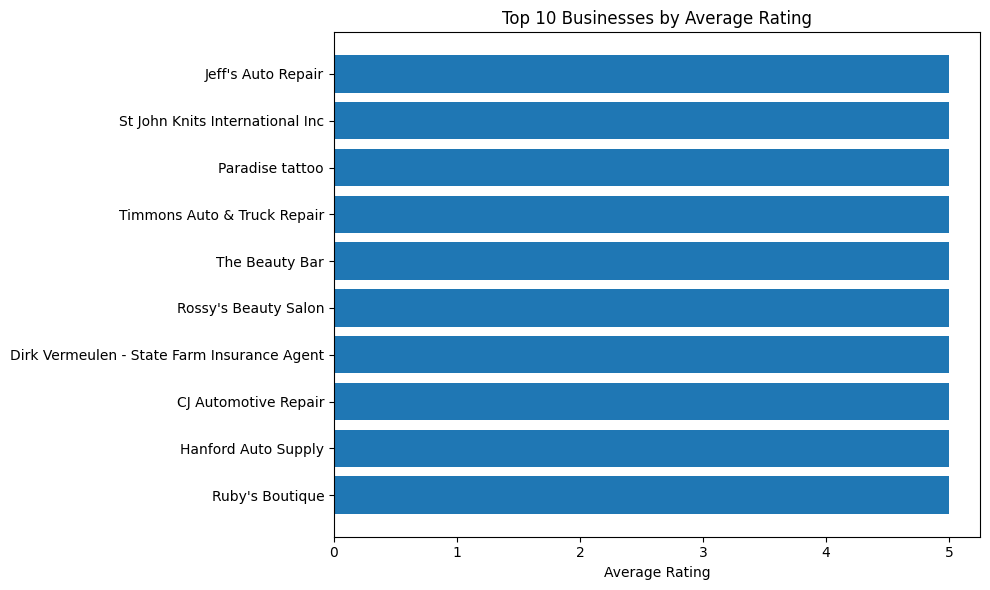

In [37]:
top10 = df_avg.limit(10).collect()

import matplotlib.pyplot as plt

names = [row["business_name"] for row in top10]
ratings = [row["avg_rating"] for row in top10]

plt.figure(figsize=(10, 6))
plt.barh(names[::-1], ratings[::-1])
plt.xlabel("Average Rating")
plt.title("Top 10 Businesses by Average Rating")
plt.tight_layout()
plt.show()

In [38]:
from pyspark.sql.functions import count

df_most_reviewed = df_selected.groupBy("gmap_id", "business_name") \
    .agg(count("rating").alias("review_count")) \
    .orderBy("review_count", ascending=False)

In [39]:
top10_most_reviewed = df_most_reviewed.limit(10).collect()

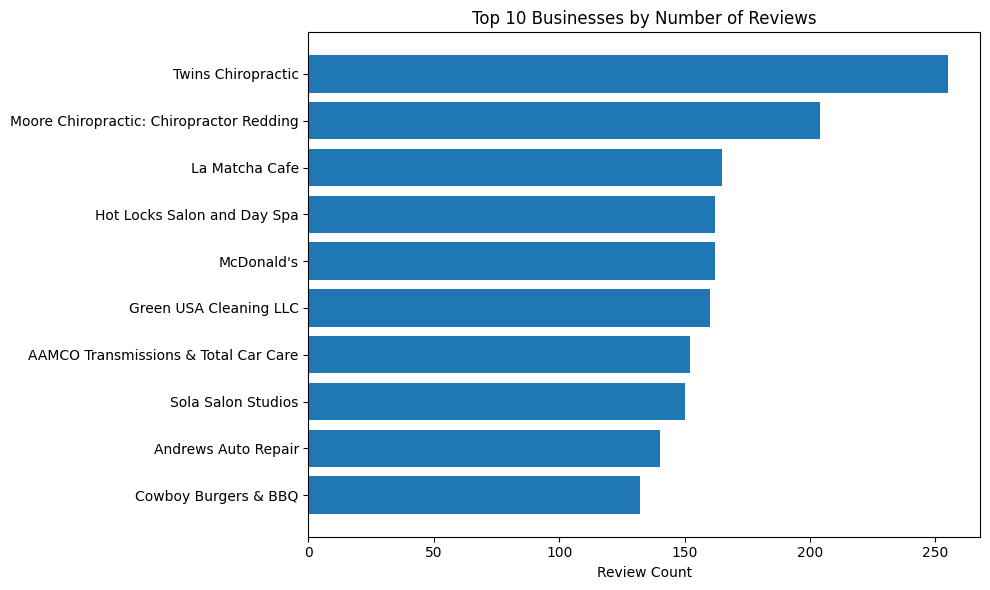

In [40]:
import matplotlib.pyplot as plt

names = [row["business_name"] for row in top10_most_reviewed]
counts = [row["review_count"] for row in top10_most_reviewed]

plt.figure(figsize=(10, 6))
plt.barh(names[::-1], counts[::-1])
plt.xlabel("Review Count")
plt.title("Top 10 Businesses by Number of Reviews")
plt.tight_layout()
plt.show()

In [41]:
from pyspark.sql.functions import when, count

df_buckets = df_selected.select("rating").withColumn(
    "rating_bucket",
    when((col("rating") >= 1) & (col("rating") < 2), "1-2")
    .when((col("rating") >= 2) & (col("rating") < 3), "2-3")
    .when((col("rating") >= 3) & (col("rating") < 4), "3-4")
    .when((col("rating") >= 4) & (col("rating") <= 5), "4-5")
    .otherwise("invalid")
)

df_bucket_count = df_buckets.groupBy("rating_bucket").agg(count("*").alias("count"))

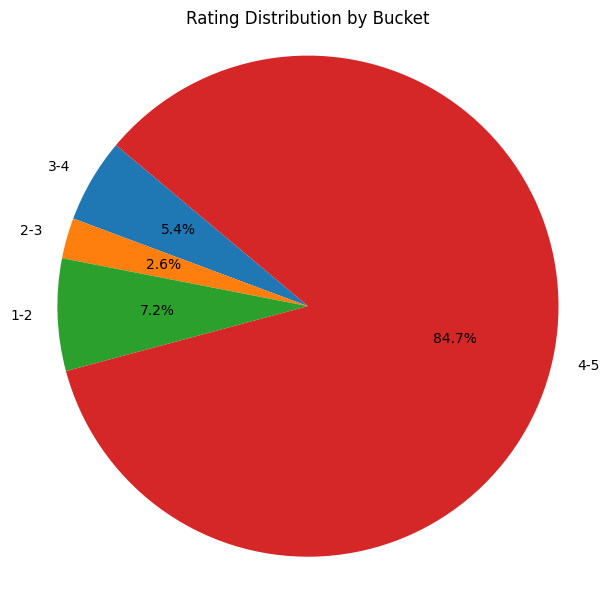

In [42]:
bucket_data = df_bucket_count.collect()

labels = [row["rating_bucket"] for row in bucket_data]
sizes = [row["count"] for row in bucket_data]

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140)
plt.title("Rating Distribution by Bucket")
plt.axis("equal")
plt.tight_layout()
plt.show()

## 💾 Step 5: Save Back to MongoDB

In [43]:
top10_dicts = [
    {
        "gmap_id": row["gmap_id"],
        "business_name": row["business_name"],
        "avg_rating": float(row["avg_rating"]),
    }
    for row in top10
]


In [44]:
from pymongo import MongoClient

client = MongoClient("mongodb://localhost:27017/")
db = client["group6_bigdata"]
db["top10_avg_rating"].drop()
db["top10_avg_rating"].insert_many(top10_dicts)

InsertManyResult([ObjectId('67f8190522cdf447ccae7cce'), ObjectId('67f8190522cdf447ccae7ccf'), ObjectId('67f8190522cdf447ccae7cd0'), ObjectId('67f8190522cdf447ccae7cd1'), ObjectId('67f8190522cdf447ccae7cd2'), ObjectId('67f8190522cdf447ccae7cd3'), ObjectId('67f8190522cdf447ccae7cd4'), ObjectId('67f8190522cdf447ccae7cd5'), ObjectId('67f8190522cdf447ccae7cd6'), ObjectId('67f8190522cdf447ccae7cd7')], acknowledged=True)

In [45]:
top10_dicts = [
    {
        "gmap_id": row["gmap_id"],
        "business_name": row["business_name"],
        "review_count": int(row["review_count"]),
    }
    for row in top10_most_reviewed
]


In [46]:
from pymongo import MongoClient

client = MongoClient("mongodb://localhost:27017/")
db = client["group6_bigdata"]
db["top10_review_count"].drop()
db["top10_review_count"].insert_many(top10_dicts)

InsertManyResult([ObjectId('67f8190522cdf447ccae7cd9'), ObjectId('67f8190522cdf447ccae7cda'), ObjectId('67f8190522cdf447ccae7cdb'), ObjectId('67f8190522cdf447ccae7cdc'), ObjectId('67f8190522cdf447ccae7cdd'), ObjectId('67f8190522cdf447ccae7cde'), ObjectId('67f8190522cdf447ccae7cdf'), ObjectId('67f8190522cdf447ccae7ce0'), ObjectId('67f8190522cdf447ccae7ce1'), ObjectId('67f8190522cdf447ccae7ce2')], acknowledged=True)

In [47]:
docs = [
    {
        "bucket": row["rating_bucket"],
        "count": int(row["count"]),
    }
    for row in bucket_data
]

In [48]:
db["rating_distribution"].drop()
db["rating_distribution"].insert_many(docs)

InsertManyResult([ObjectId('67f8190522cdf447ccae7ce3'), ObjectId('67f8190522cdf447ccae7ce4'), ObjectId('67f8190522cdf447ccae7ce5'), ObjectId('67f8190522cdf447ccae7ce6')], acknowledged=True)